<a href="https://colab.research.google.com/github/warriors8970/Gen-AI/blob/main/Image%20Generation/Diffusion%20Models/diffusion_model_2/diffusion_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as f
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Current device: {device}")

Current device: cuda


# Importing Data
Dataset used: `mnist`

In [ ]:
dataset = torchvision.datasets.MNIST(root = "/content/drive/MyDrive", train = True, download = True, transform = torchvision.transforms.ToTensor())

In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
train_dataloader = DataLoader(dataset=dataset,
                              batch_size = 8,
                              shuffle = True)

In [ ]:
train_dataloader

Input shape:  torch.Size([8, 1, 28, 28])
Labels:  tensor([4, 1, 7, 9, 9, 5, 4, 0])


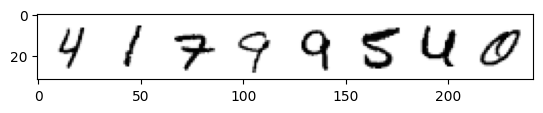

In [ ]:
x,y = next(iter(train_dataloader))
print("Input shape: ", x.shape)
print("Labels: ", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Corruption of data
- `x` - Input image tensor
- `amount` - The amount needed to be corrupted

In [ ]:
def corrupt(x, amount):
  noise = torch.rand_like(x)
  amount = amount.view(-1,1,1,1) # Changes the shape so it goes with the rules
  return x*(1-amount)+ noise*amount # (1-amount) cuz values will be within 0 to 1

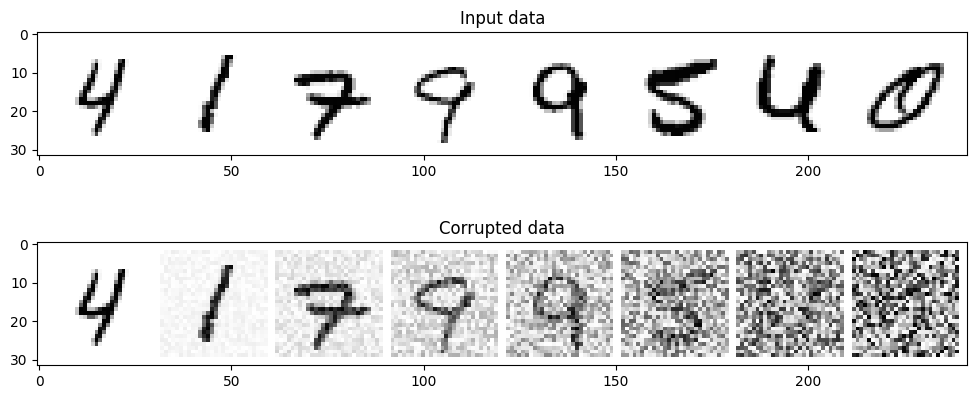

In [ ]:
# Visualizing this shit
fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].set_title("Input data")
ax[0].imshow(torchvision.utils.make_grid(x)[0], cmap = "Greys")

amount = torch.linspace(0,1,x.shape[0])
noised_x = corrupt(x,amount)

ax[1].set_title("Corrupted data")
ax[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap= "Greys")

In [ ]:
x[0], noised_x[3]

# Building the model: `BasicUNet()`
- In channels and out channels are 1 as we are taking grey scale images


In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

Verifying the model with input size and check if same is returned as output

In [ ]:
model1 = BasicUNet()
x = torch.rand(8,1,28,28)
model1(x).shape

torch.Size([8, 1, 28, 28])

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary

summary(model1, input_size = [8,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
BasicUNet                                [8, 1, 28, 28]            --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-1                       [8, 32, 28, 28]           832
├─SiLU: 1-2                              [8, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [8, 32, 14, 14]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-2                       [8, 64, 14, 14]           51,264
├─SiLU: 1-5                              [8, 64, 14, 14]           --
├─MaxPool2d: 1-6                         [8, 64, 7, 7]             --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-3                       [8, 64, 7, 7]             102,464
├─SiLU: 1-8                              [8, 64, 7, 7]             --
├─ModuleList: 1-15                       --     

# Training Loop
**Steps:**
* Get data
* Corrupt the data by random amounts
* feed it to model
* compare with preds and calculate loss
* optimizer step

We will use:
  - Optimizer - `Adam()`
  - Loss - `MSELoss()`

In [ ]:
x,y in train_dataloader
x.shape, y
# So train_dataloader consist of images in batch of 8 and its labels

(torch.Size([8, 1, 28, 28]), tensor([8, 0, 1, 2, 1, 1, 9, 5]))

In [ ]:
torch.rand(x.shape[0]).to(device)

tensor([0.0606, 0.4772, 0.1053, 0.2314, 0.7784, 0.8118, 0.2543, 0.4180],
       device='cuda:0')

In [ ]:
from torch.optim import Adam
from tqdm.auto import tqdm

BATCH_SIZE = 128
train_dataloader = DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

EPOCHS = 3

model1 = BasicUNet()
model1.to(device)

loss_fn = nn.MSELoss()

optimizer = Adam(params= model1.parameters(),
                 lr = 1e-3)

losses = []

for epoch in tqdm(range(EPOCHS)):
  for x,y in train_dataloader:
    x = x.to(device)
    noise_amount = torch.rand(x.shape[0]).to(device)
    noisy_x = corrupt(x, noise_amount)

    pred = model1(noisy_x)

    loss = loss_fn(pred, x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)

  print(f"Epoch: {epoch} | Average loss: {avg_loss}")



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 | Average loss: 0.027050442719605685
Epoch: 1 | Average loss: 0.020612416111790675
Epoch: 2 | Average loss: 0.01866388301660956


(0.0, 0.1)

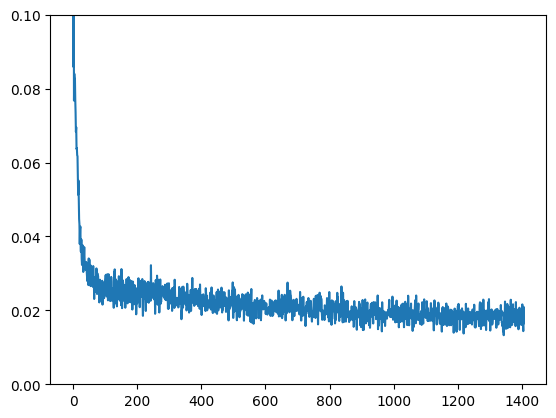

In [ ]:
plt.plot(losses)
plt.ylim(0,0.1)

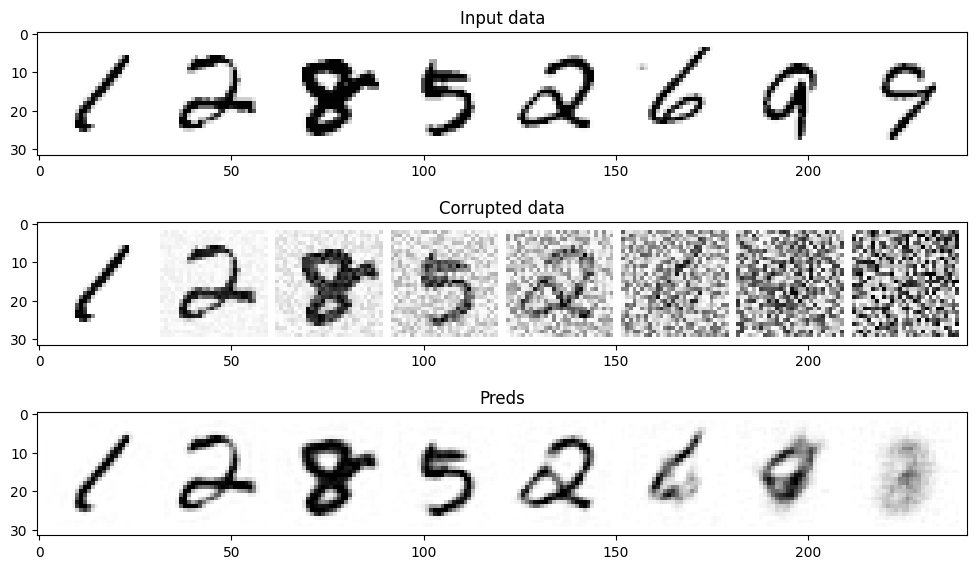

In [ ]:
torch.random.manual_seed(42)
x, y = next(iter(train_dataloader))

x = x[:8]

amount = torch.linspace(0,1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
  pred = model1(noised_x.to(device)).detach().cpu()

fig, ax = plt.subplots(3,1, figsize=(12,7))
ax[0].set_title("Input data")
ax[0].imshow(torchvision.utils.make_grid(x)[0].clip(0,1), cmap='Greys')

ax[1].set_title("Corrupted data")
ax[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0,1), cmap='Greys')

ax[2].set_title("Preds")
ax[2].imshow(torchvision.utils.make_grid(pred)[0].clip(0,1), cmap='Greys')



# Sampling to increase the accuracy - image structure

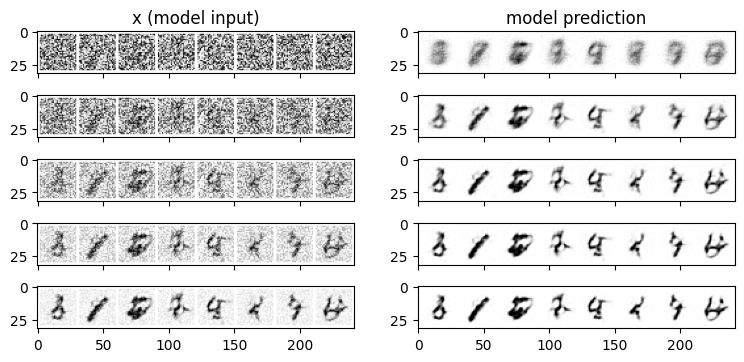

In [ ]:
n_steps = 5

x =torch.rand(8,1,28,28).to(device) # Random noise as input
step_history = [x.detach().cpu()] # Move to cpu
pred_output = []

for i in range(n_steps):
  with torch.no_grad():
    pred = model1(x)
  pred_output.append(pred.detach().cpu())
  mix_factor = 1/(n_steps-i)
  x = x*(1-mix_factor) + pred*mix_factor
  step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output[i])[0].clip(0, 1), cmap='Greys')